<a href="https://colab.research.google.com/github/open-mmlab/mmsegmentation/blob/main/demo/MMSegmentation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMSegmentation For Fishes
Welcome to MMSegmentation! 

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results. 

## Finetune a semantic segmentation model on a new dataset

To finetune on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure. 

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data) for details about dataset reorganization. 

We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

In [44]:
# Background      0
# Head            1
# Eye             2
# Dorsal fin      3
# Pectoral fin    4
# Pelvic fin      5
# Anal fin        6
# Caudal fin      7
# Adipose fin     8
# Barbel          9

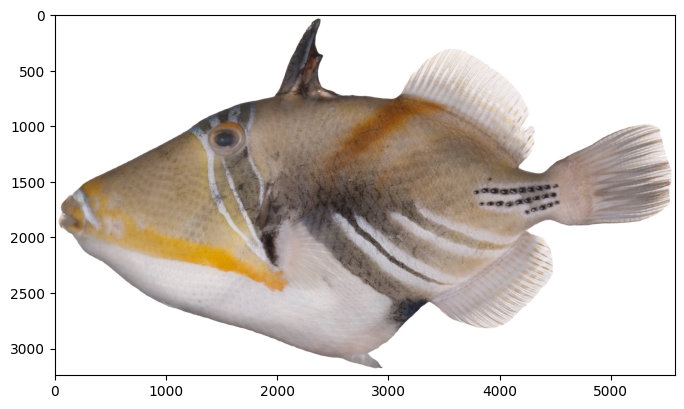

In [31]:
# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import os.path as osp
import numpy as np
from PIL import Image


img = mmcv.imread('/raid/segmentation_dataset/images/m3f9f60803-e7d1-46c5-a91e-44f56c8962fc.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [2]:
data_root="./"
img_dir = os.path.join(data_root, "images/")
ann_dir = os.path.join(data_root, "annotations/")

## Distribution of traits across train-val-test

In [20]:
'''
change the path and filenames
'''
with open('./train_label.txt') as f:
    train_labels = f.readlines()

with open('./val_label.txt') as f:
    val_labels = f.readlines()

with open('./test_label.txt') as f:
    test_labels = f.readlines()

In [22]:
train_labels = [i.replace('\n', '') for i in train_labels]
val_labels = [i.replace('\n', '') for i in val_labels]
test_labels = [i.replace('\n', '') for i in test_labels]

In [41]:
print(f"Number of train samples = {len(train_labels)}")
print(f"Number of val samples = {len(val_labels)}")
print(f"Number of test samples = {len(test_labels)}")

Number of train samples = 1707
Number of val samples = 120
Number of test samples = 600


In [32]:
train_count = [0]*10
for label in tqdm(train_labels):
    uniques = np.unique(np.load('./annotations/'+label.replace('.jpg', '.npy')))
    for mask in uniques:
        train_count[mask] += 1

100%|████████████████████████████████████████████████████████████████████████| 1707/1707 [02:34<00:00, 11.04it/s]


In [34]:
print(train_count)

[1707, 1691, 1664, 1643, 1686, 1578, 1652, 1661, 306, 187]


In [35]:
test_count = [0]*10
for label in tqdm(test_labels):
    uniques = np.unique(np.load('./annotations/'+label.replace('.jpg', '.npy')))
    for mask in uniques:
        test_count[mask] += 1

val_count = [0]*10
for label in tqdm(val_labels):
    uniques = np.unique(np.load('./annotations/'+label.replace('.jpg', '.npy')))
    for mask in uniques:
        val_count[mask] += 1

100%|██████████████████████████████████████████████████████████████████████████| 120/120 [00:10<00:00, 11.05it/s]


In [36]:
val_count

[120, 118, 119, 117, 120, 112, 117, 118, 25, 11]

In [37]:
test_count

[600, 597, 595, 587, 596, 566, 590, 589, 105, 70]

We need to convert the annotation into semantic map format as an image.

In [6]:
# define class and palette for better visualization

# Background      0
# Head            1
# Eye             2
# Dorsal fin      3
# Pectoral fin    4
# Pelvic fin      5
# Anal fin        6
# Caudal fin      7
# Adipose fin     8
# Barbel          9
classes = ('Background', 'Head', 'Eye', 'Dorsal fin', 'Pectoral fin', 'Pelvic fin', 'Anal fin', 'Caudal fin', 'Adipose fin', 'Barbel')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34],
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51],
           [255, 165, 0], [153, 50, 204]]  # Added two new colors

In [12]:
# convert dataset annotation to semantic segmentation map
for file in mmengine.scandir(osp.join(data_root, ann_dir)):
    seg_map = np.load(osp.join(data_root, ann_dir, file)).astype(np.uint8)
    seg_img = Image.fromarray(seg_map).convert('P')
    seg_img.putpalette(np.array(palette, dtype=np.uint8))
    seg_img.save(osp.join('./segmentation_maps', file.replace('.npy', '.png')))

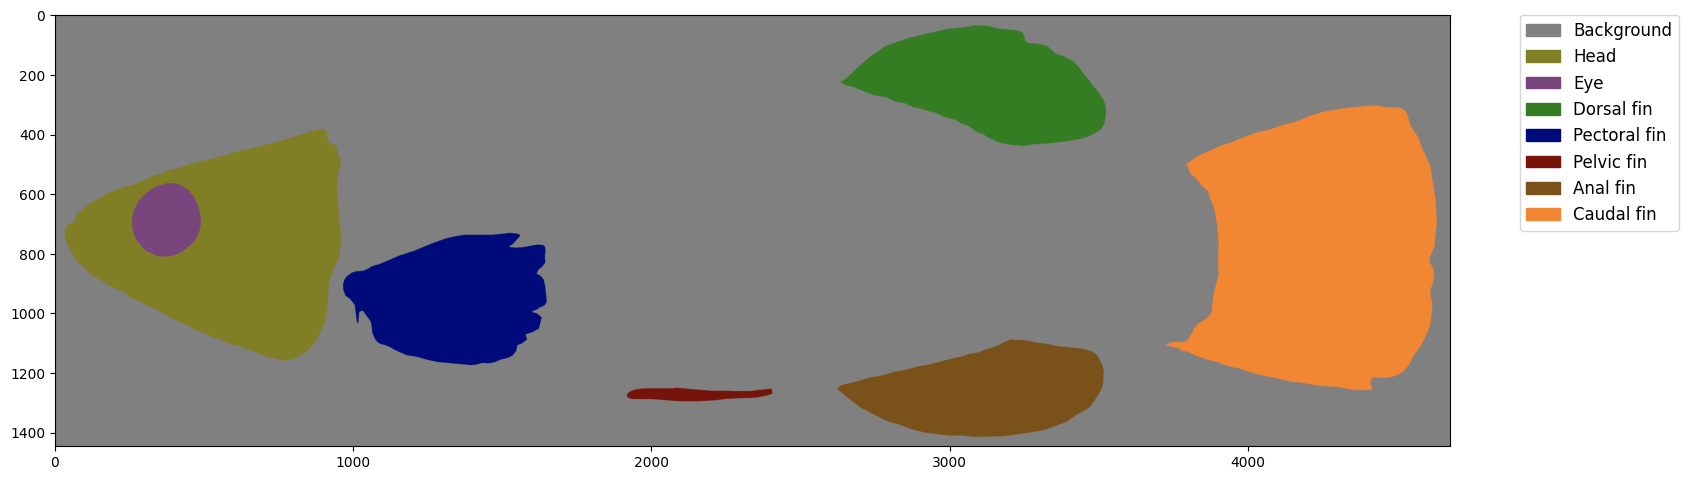

In [7]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open(os.path.join('./segmentation_maps', all_files_anno[0] +'.png'))
plt.figure(figsize=(18, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [8]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

@DATASETS.register_module()
class FishForTraits(BaseSegDataset):
    METAINFO = dict(classes=classes, palette=palette)
    def __init__(self, **kwargs):
        super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [9]:
# Download config and checkpoint files
!mim download mmsegmentation --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest .

processing pspnet_r50-d8_4xb2-40k_cityscapes-512x1024...
pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth exists in /home/abhilash22/FishTraitSegmentation
Successfully dumped pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py to /home/abhilash22/FishTraitSegmentation


In [10]:
mmseg_config_path="../mmsegmentation/"

In [11]:
from mmengine import Config
cfg = Config.fromfile(mmseg_config_path+'configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    512,
    1024,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'data/cityscapes/'
dataset_type = 'CityscapesDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=4000, type='CheckpointHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [12]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 8
cfg.model.auxiliary_head.num_classes = 8

# Modify dataset type and path
cfg.dataset_type = 'FishForTraits'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path="images", seg_map_path='segmentation_maps/')
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = cfg.data_root+'train_label.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path="images", seg_map_path='segmentation_maps/')
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = cfg.data_root+'val_label.txt'

cfg.test_dataloader.dataset.type = cfg.dataset_type
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path='segmentation_maps/')
cfg.test_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.test_dataloader.dataset.ann_file = cfg.data_root+'test_label.txt'


# Load the pretrained weights
cfg.load_from = 'pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './fish_work_dir/'

cfg.train_cfg.max_iters = 200
cfg.train_cfg.val_interval = 200
cfg.default_hooks.logger.interval = 10
cfg.default_hooks.checkpoint.interval = 200

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    256,
    256,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = './'
dataset_type = 'FishForTraits'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=200, type='CheckpointHook'),
    logger=dict(interval=10, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.75,
]
load_from = 'p

In [13]:
cfg.train_dataloader

{'batch_size': 8,
 'num_workers': 2,
 'persistent_workers': True,
 'sampler': {'type': 'InfiniteSampler', 'shuffle': True},
 'dataset': {'type': 'FishForTraits',
  'data_root': './',
  'data_prefix': {'img_path': 'images', 'seg_map_path': 'segmentation_maps/'},
  'pipeline': [{'type': 'LoadImageFromFile'},
   {'type': 'LoadAnnotations'},
   {'type': 'RandomResize',
    'scale': (320, 240),
    'ratio_range': (0.5, 2.0),
    'keep_ratio': True},
   {'type': 'RandomCrop', 'crop_size': (256, 256), 'cat_max_ratio': 0.75},
   {'type': 'RandomFlip', 'prob': 0.5},
   {'type': 'PackSegInputs'}],
  'ann_file': './train_label.txt'}}

In [14]:
cfg.test_dataloader

{'batch_size': 1,
 'num_workers': 4,
 'persistent_workers': True,
 'sampler': {'type': 'DefaultSampler', 'shuffle': False},
 'dataset': {'type': 'FishForTraits',
  'data_root': './',
  'data_prefix': {'img_path': './images/',
   'seg_map_path': 'segmentation_maps/'},
  'pipeline': [{'type': 'LoadImageFromFile'},
   {'type': 'Resize', 'scale': (320, 240), 'keep_ratio': True},
   {'type': 'LoadAnnotations'},
   {'type': 'PackSegInputs'}],
  'ann_file': './test_label.txt'}}

In [15]:
cfg.val_dataloader

{'batch_size': 1,
 'num_workers': 4,
 'persistent_workers': True,
 'sampler': {'type': 'DefaultSampler', 'shuffle': False},
 'dataset': {'type': 'FishForTraits',
  'data_root': './',
  'data_prefix': {'img_path': 'images', 'seg_map_path': 'segmentation_maps/'},
  'pipeline': [{'type': 'LoadImageFromFile'},
   {'type': 'Resize', 'scale': (320, 240), 'keep_ratio': True},
   {'type': 'LoadAnnotations'},
   {'type': 'PackSegInputs'}],
  'ann_file': './val_label.txt'}}

In [16]:
# import shutil
# from tqdm import tqdm
# img_path='/raid/segmentation_dataset/images/'
# shutil.copyfile('/raid/segmentation_dataset/train_label.txt', './train_label.txt')
# shutil.copyfile('/raid/segmentation_dataset/val_label.txt', './val_label.txt')
# shutil.copyfile('/raid/segmentation_dataset/test_label.txt', './test_label.txt')
# for file in tqdm(os.listdir('./annotations/')):
#     shutil.copyfile(img_path+file.replace('.npy', '.jpg'), './images/'+file.replace('.npy', '.png'))

### Train and Evaluation

In [17]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

05/25 19:22:50 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.19 (default, Mar 20 2024, 19:58:24) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0,1,2,3,4,5,6,7: NVIDIA TITAN RTX
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 10.2, V10.2.8
    GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.11.0+cu102
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.5.2 (Git Hash a9302535553c73243c632ad3c4c80beec3d19a1e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.2
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-genco

/home/abhilash22/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/abhilash22/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/abhilash22/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


05/25 19:22:54 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
05/25 19:22:54 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/home/abhilash22/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [18]:
# start training
runner.train()

05/25 19:22:56 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
05/25 19:22:57 - mmengine - INFO - load model from: open-mmlab://resnet50_v1c
05/25 19:22:57 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet50_v1c
05/25 19:22:57 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

Loads checkpoint by local backend from path: pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([8]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape tor

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

In [40]:
runner.test()

05/25 19:54:42 - mmengine - INFO - Iter(test) [ 10/600]    eta: 0:01:18  time: 0.1323  data_time: 0.0900  memory: 2411  
05/25 19:54:43 - mmengine - INFO - Iter(test) [ 20/600]    eta: 0:01:11  time: 0.1126  data_time: 0.0497  memory: 5292  
05/25 19:54:44 - mmengine - INFO - Iter(test) [ 30/600]    eta: 0:00:57  time: 0.0574  data_time: 0.0128  memory: 2369  
05/25 19:54:44 - mmengine - INFO - Iter(test) [ 40/600]    eta: 0:00:50  time: 0.0564  data_time: 0.0162  memory: 5139  
05/25 19:54:46 - mmengine - INFO - Iter(test) [ 50/600]    eta: 0:00:58  time: 0.1759  data_time: 0.0277  memory: 9754  
05/25 19:54:48 - mmengine - INFO - Iter(test) [ 60/600]    eta: 0:01:02  time: 0.1631  data_time: 0.0378  memory: 9811  
05/25 19:54:48 - mmengine - INFO - Iter(test) [ 70/600]    eta: 0:00:55  time: 0.0327  data_time: 0.0073  memory: 1914  
05/25 19:54:49 - mmengine - INFO - Iter(test) [ 80/600]    eta: 0:00:51  time: 0.0557  data_time: 0.0204  memory: 1907  
05/25 19:54:49 - mmengine - INFO

{'aAcc': 89.69, 'mIoU': 35.23, 'mAcc': 41.65}

Inference with trained model

Loads checkpoint by local backend from path: ./fish_work_dir/iter_200.pth


/home/abhilash22/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


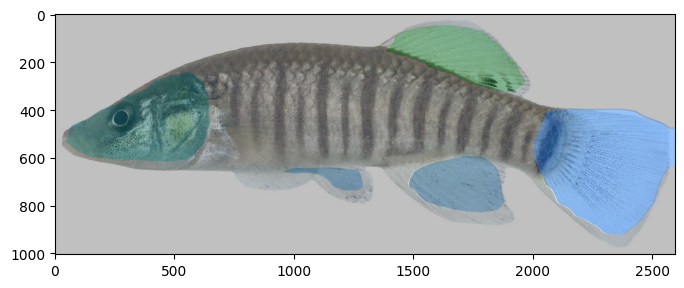

In [38]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = './fish_work_dir/iter_200.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('./images/18e704cc-3ee9-4d54-bd6d-1dc2ae27d6bc.png') #sample from test images
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))